In [1]:
# So we can import our modules 
import sys
sys.path.append('../..')

from src.utils.data import load_split, get_transforms
from src.utils.model import init_model, predict
from src.datasets.pornography_frame_dataset import PornographyFrameDataset

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from zennit.attribution import Gradient, SmoothGrad
from zennit.composites import EpsilonPlusFlat
from zennit.image import imgify

In [4]:
MODEL_NAME = "vgg19"
MODEL_PATH = "../../results/even-20/data-aug/pornography-2k/models/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model = init_model(MODEL_NAME)
model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

model.eval()

Device: cpu


DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [5]:
DATA_LOC = "/nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20"
INPUT_SHAPE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
SPLIT = [0.1, 0.2]
BATCH_SIZE = 4

df_test = load_split(DATA_LOC, SPLIT, ["test"])["test"]
data_transforms = get_transforms(False, INPUT_SHAPE, MEAN, STD)["test"]
dataset = PornographyFrameDataset(DATA_LOC, df_test, data_transforms)
dataloader = DataLoader(dataset, BATCH_SIZE)

Loaded split.
test: total (8000); porn (4020); non-porn (3980)


In [6]:
name, input, label = dataset["vPorn000224#1.jpg"]
input = input.unsqueeze(0).to(device)
conf, pred = predict(model, input)
print(f"{name} - predicted: {pred.item()} (confidence: {conf.item()})")
target = F.one_hot(pred, num_classes=2)

vPorn000224#1.jpg - predicted: 1 (confidence: 0.6211549639701843)


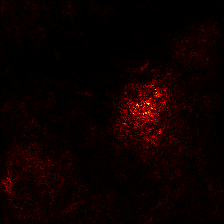

In [7]:
with Gradient(model=model) as attributor:
  _, attribution = attributor(input, target)

relevance = attribution.abs().sum(1) # absolute sum over the channels
img = imgify(relevance, symmetric=False, cmap='hot')
display(img)

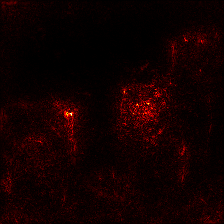

In [8]:
with SmoothGrad(noise_level=0.1, n_iter=20, model=model) as attributor:
  _, attribution = attributor(input, target)

relevance = attribution.abs().sum(1) # absolute sum over the channels
img = imgify(relevance, symmetric=False, cmap='hot')
display(img)

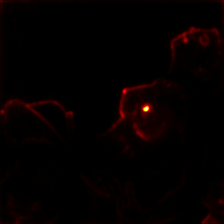

In [9]:
composite = EpsilonPlusFlat()

with Gradient(model=model, composite=composite) as attributor:
  _, attribution = attributor(input, target)

relevance = attribution.abs().sum(1) # absolute sum over the channels
img = imgify(relevance, symmetric=False, cmap='hot')
display(img)